In [1]:
from pathlib import Path
import os, sys
from geopy.geocoders import GoogleV3, Nominatim
import geopandas as gpd
import pandas as pd

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim
from SCanalyzer.busSim.manager import LocalManager
from shapely.geometry import Point
from matplotlib.lines import Line2D

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"
START_TIME = "05:00:00"
ELAPSE_TIME = "01:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 10
city = gpd.read_file("../data/plot/background/madison-shp")
lakes = gpd.read_file("../data/plot/background/water-shp")
street = gpd.read_file("../data/plot/background/street-shp")
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

In [3]:
cache = {}
def geocode(addr):
    if not "madison" in addr.lower():
        addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

In [4]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

In [5]:
def plot(starts=[]):      
    ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
    lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
    city.plot(color="black", alpha=0.05, ax=ax, zorder=2)
    street.plot(color="black", alpha=0.03, ax=ax, zorder=3)

    leg_lines = []
    leg_text = []
    
    colors = ["orange", "blue", "green", "yellow"]
    
    zorder = 4
    
    bubbles = []
    
    for i, addr in enumerate(starts):
        print(addr)
        zorder += 10
        location = geocode(addr)
        lat, lon = (location.latitude, location.longitude)
        # check if the point is indeed in Madison
        if lat > max_lat or lat < min_lat or lon > max_lon or lon < min_lon:
            print(lat, lon)
            print(f"Looks like {start} is not in madison.")
            continue
        gdf = busSim.get_gdf(start_point=(lat, lon))
        gdf = gdf.to_crs(epsg=4326)
        
        color = colors[i % len(colors)]
        bubble = flatten(gdf.difference(lakes.unary_union))
        bubble["color"] = color
        bubbles.append(bubble)
        bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
        # Round-trip the data through a flat projection, ideally one which preserves area, such as Equal Area Cylindrical ('+proj=cea')
        gdf["geometry"].to_crs('+proj=cea').centroid.to_crs(gdf.crs).plot(color="black", ax=ax, markersize=2, zorder=zorder+3)
        start = gpd.GeoSeries([Point(lon, lat)])
        start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100)
        
        leg_lines.append(Line2D([0], [0], color=color, lw=4))
        leg_text.append(addr)
        
    df = pd.concat(bubbles)
    df.plot(alpha=0.2, ax=ax, color=df["color"], zorder=zorder)

    leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("white")

    ax.set_axis_off()
    
def demo(addrs_str):
    plot([s.strip() for s in addrs_str.split("\n") if s.strip() != ""])

The Nat


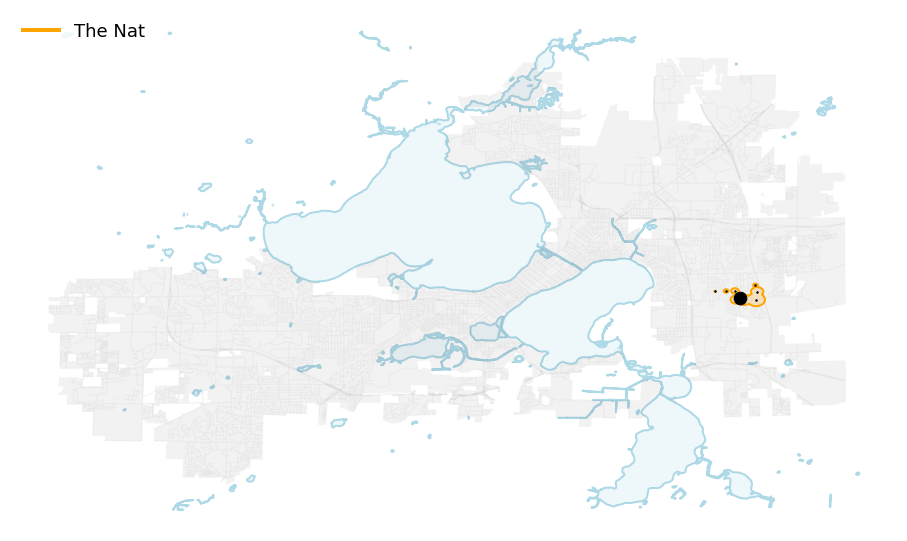

In [6]:
demo("""
The Nat
""")

330 N Orchard St
The Nat
Olbrich Gardens


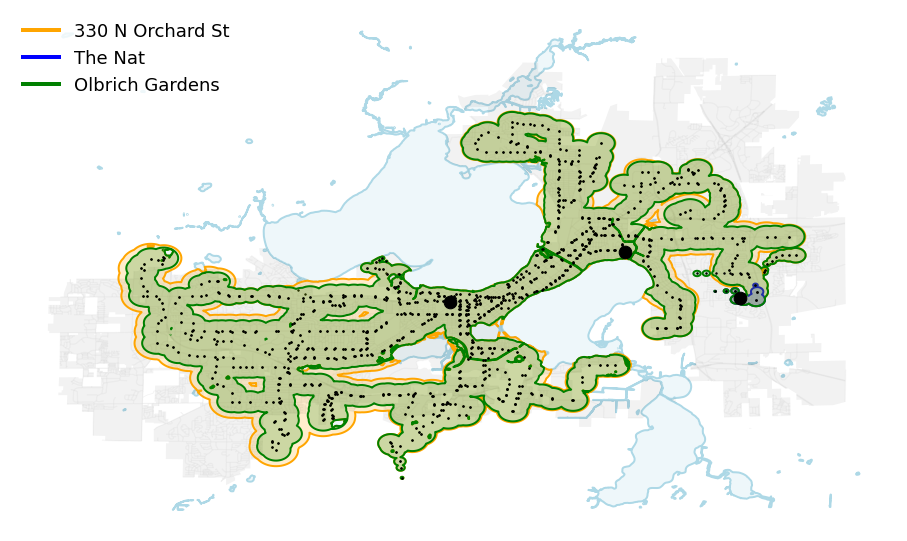

In [7]:
demo("""
330 N Orchard St
The Nat
Olbrich Gardens
""")

330 N Orchard St
The Nat
Olbrich Gardens


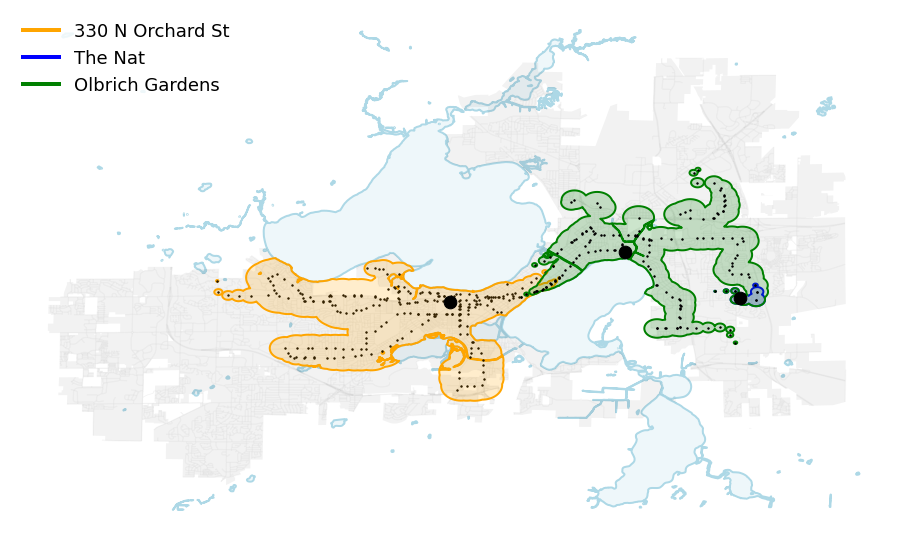

In [6]:
demo("""
330 N Orchard St
The Nat
Olbrich Gardens
""")

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
start_times = ['05:00:00',
 '05:05:00',
 '05:10:00',
 '05:15:00',
 '05:20:00',
 '05:25:00',
 '05:30:00',
 '05:35:00',
 '05:40:00',
 '05:45:00',
 '05:50:00',
 '05:55:00',
 '06:00:00',
 '06:05:00',
 '06:10:00',
 '06:15:00',
 '06:20:00',
 '06:25:00',
 '06:30:00',
 '06:35:00',
 '06:40:00',
 '06:45:00',
 '06:50:00',
 '06:55:00',
 '07:00:00',
 '07:05:00',
 '07:10:00',
 '07:15:00',
 '07:20:00',
 '07:25:00',
 '07:30:00',
 '07:35:00',
 '07:40:00',
 '07:45:00',
 '07:50:00',
 '07:55:00',
 '08:00:00',
 '08:05:00',
 '08:10:00',
 '08:15:00',
 '08:20:00',
 '08:25:00',
 '08:30:00',
 '08:35:00',
 '08:40:00',
 '08:45:00',
 '08:50:00',
 '08:55:00',
 '09:00:00',
 '09:05:00',
 '09:10:00',
 '09:15:00',
 '09:20:00',
 '09:25:00',
 '09:30:00',
 '09:35:00',
 '09:40:00',
 '09:45:00',
 '09:50:00',
 '09:55:00',
 '10:00:00',
 '10:05:00',
 '10:10:00',
 '10:15:00',
 '10:20:00',
 '10:25:00',
 '10:30:00',
 '10:35:00',
 '10:40:00',
 '10:45:00',
 '10:50:00',
 '10:55:00']
b = list(range(0,len(start_times)))

In [28]:
from datetime import datetime
datetime.strptime(start_times[0], "%H:%M:%S")
a = list(map(lambda x: datetime.strptime(x, "%H:%M:%S"), start_times))

In [12]:
len(start_times)

72

In [13]:
len(b)

72

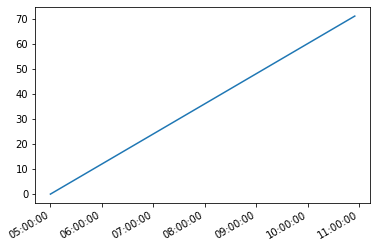

In [33]:
from matplotlib.dates import DateFormatter
plt.plot(a,b)
formatter = DateFormatter("%H:%M:%S")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate()